# Relative power purchasing parity - Euro/USD FX rate prediction

**Linh Bao Pham**

*Project: Business Analytic Capstone*

## A. Data retrieving
### 1. Setting up librabries and variables

In [1]:
# Import libraries
import requests
import pandas as pd
import numpy as np

**For the country code and index codes used below, it can be found on the country list and datacode list of IFS**

In [2]:
#Define list of country and index for data retrieve
country=[['Euro', 'U2','DE'], ['JapanYen', 'JP','JP'], ['GBPound', 'GB','GB'],['Canada$','CA','CA']]
country = pd.DataFrame(country, columns = ['currency', 'currency_code','country_code'])
index=[['cpi','PCPI_IX'],['ppi','PPPI_IX'],['pmp','PMP_IX'],['pxp','PXP_IX']]
index = pd.DataFrame(index, columns = ['price_index', 'code'])
print(country)
print(' ')
print(index)

#Define other attribute for url
startperiod='1960'
endperiod='2020'
freq='M' #data frequency, can be 'M'-monthly, 'Q'-quarterly and 'A'-annually

   currency currency_code country_code
0      Euro            U2           DE
1  JapanYen            JP           JP
2   GBPound            GB           GB
3   Canada$            CA           CA
 
  price_index     code
0         cpi  PCPI_IX
1         ppi  PPPI_IX
2         pmp   PMP_IX
3         pxp   PXP_IX


### 2. Data call for Euro currency (using price indices from Germany)

The script below is used to 
* call data from IFS via API link
* append/merge/join data set between fx and price indices
* format the data (date, number, etc.)


In [3]:
eu_data=pd.DataFrame() #create blank data frame to append data
#for i in range(len(country)):
label=country.loc[0,'currency']
currency_code=country.loc[0,'currency_code']
country_code=country.loc[0,'country_code']

#Extract exchange rate data - using currency code:
url='http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/{}.{}.ENDE_XDC_USD_RATE.?startPeriod={}&endPeriod={}'.format(freq,
                                                                                                                                 currency_code,
                                                                                                                                 startperiod,
                                                                                                                                 endperiod)
print(url) #print to check
request = requests.get(url).json()
#print(request) #print to check
fx = pd.DataFrame(request['CompactData']['DataSet']['Series']['Obs'])
fx.columns=['fx','time']
fx['currency']=label
#print(fx.head())#print to check
    
# Extract Price indices data from IFS database
        
eu_data=fx
eu_data.head()

http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/M.U2.ENDE_XDC_USD_RATE.?startPeriod=1960&endPeriod=2020


,fx,time,currency
0,0.878425860857344,1999-01,Euro
1,0.907605736068252,1999-02,Euro
2,0.930925339787749,1999-03,Euro
3,0.943663300934227,1999-04,Euro
4,0.956388676358072,1999-05,Euro


In [4]:
# Formatting the data
## format column from char to number
eu_data['fx']=eu_data['fx'].astype(float) 

## format time to date format
eu_data['time']=pd.to_datetime(eu_data['time'])

# Review data after formatting
eu_data.head()

,fx,time,currency
0,0.878426,1999-01-01,Euro
1,0.907606,1999-02-01,Euro
2,0.930925,1999-03-01,Euro
3,0.943663,1999-04-01,Euro
4,0.956389,1999-05-01,Euro


### 3. Data call for US price index

To create the purchasing power parity value, we need to have US price index to be the denominator. Using the same process to call the data in section 2, we will replicate to call the data for US price index

In [5]:
us_price_index=pd.DataFrame()
country_code='US'

for j in range(len(index)):
    #print(j)
    code = index.loc[j,'code']
    index_n=index.loc[j,'price_index']
    url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/{}.{}.{}.?startPeriod={}&endPeriod={}'.format(freq,
                                                                                                                        country_code,
                                                                                                                        code,
                                                                                                                        startperiod,
                                                                                                                        endperiod)
    #print(url)
    #print(index_n)
    #print(code)
    request = requests.get(url).json()
    data=pd.DataFrame(request['CompactData']['DataSet']['Series']['Obs'])
    
    if data.shape[1]>2:
        data=data.drop(data.columns[0], axis = 1)
    
    data.columns=[index_n,'time']
    
    if len(us_price_index)==0:
        us_price_index=data
    else:
        us_price_index = pd.merge(left=us_price_index, right=data, left_on='time', right_on='time')

us_price_index.head()

,cpi,time,ppi,pmp,pxp
0,16.3261188092022,1969-01,19.2840301166769,14.3079471740961,21.558814316427
1,16.4178385777933,1969-02,19.3764751316188,14.3079471740961,21.8227997974127
2,16.5554182306798,1969-03,19.4874091495489,14.4967063716435,21.7348046369375
3,16.6471379992708,1969-04,19.5058981527222,14.4589545317565,21.8227997974127
4,16.6929978835663,1969-05,19.6538101764442,14.3456990136055,21.558814316427


In [6]:
# Formatting the data
## format column from char to number
for i in index['price_index']:
    us_price_index[i]=us_price_index[i].astype(float)

## format time to date format
us_price_index['time']=pd.to_datetime(us_price_index['time'])

# Rename and rearrange colum
us_price_index.columns=['us_cpi','time','us_ppi','us_pmp','us_pxp']
us_price_index=us_price_index[['time','us_cpi','us_ppi','us_pmp','us_pxp']]

# Review data after formatting
us_price_index.head()

,time,us_cpi,us_ppi,us_pmp,us_pxp
0,1969-01-01,16.326119,19.284030,14.307947,21.558814
1,1969-02-01,16.417839,19.376475,14.307947,21.822800
2,1969-03-01,16.555418,19.487409,14.496706,21.734805
3,1969-04-01,16.647138,19.505898,14.458955,21.822800
4,1969-05-01,16.692998,19.653810,14.345699,21.558814


## B. Data processing

To have the data ready for model, the following steps are conducted:
* adding US price index
* creating input variable: 1m future exchange rate, purchasing power parity = (country price index)/(US price index)
* format the dataset (number/date format) (if needed)

### **1. Adding US price indices to the data set**

In [7]:
df = pd.merge(left=eu_data, right=us_price_index, left_on='time', right_on='time')
df.tail()

,fx,time,currency,us_cpi,us_ppi,us_pmp,us_pxp
245,0.878735,2019-06-01,Euro,117.466883,116.512485,99.060138,102.253807
246,0.896781,2019-07-01,Euro,117.663164,116.708964,99.217877,102.497462
247,0.906125,2019-08-01,Euro,117.657202,116.610725,98.508051,101.928934
248,0.918358,2019-09-01,Euro,117.749380,116.119525,98.586921,101.685279
249,0.896539,2019-10-01,Euro,118.018578,116.807204,98.113704,101.604061


### **2. Adding input variables required for modelling**

Main tasks in this sections are:
* Adding future exchange rate (exchange rate 1m/3m/12m from now)
* Calculate ppp term
* Transform fx and ppp into log term


#### **2.1. Creating future one month exchange rate column**

In [8]:
df['fx_1m'] = ""
for i in range(len(df)-1):
    df.loc[i,'fx_1m']=df.loc[i+1,'fx']/1
    
#df['fx_1m']=df['fx_1m'].astype(float)
df.tail()

,fx,time,currency,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m
245,0.878735,2019-06-01,Euro,117.466883,116.512485,99.060138,102.253807,0.896781
246,0.896781,2019-07-01,Euro,117.663164,116.708964,99.217877,102.497462,0.906125
247,0.906125,2019-08-01,Euro,117.657202,116.610725,98.508051,101.928934,0.918358
248,0.918358,2019-09-01,Euro,117.749380,116.119525,98.586921,101.685279,0.896539
249,0.896539,2019-10-01,Euro,118.018578,116.807204,98.113704,101.604061,


#### **2.2. Calculate ppp term**

Instruction and description from the research:

*To illustrate exactly how the relative ppp equilibrium rate is constructed, consider the US Dollar–British
Pound exchange rate in January 1969 of US 2.39/£. The inflation of US Export prices in February 1969
was 1.18 percent, while the inflation of US Import prices for the same period was 0.00 percent. If US Export
prices are being used in place of the domestic rate of inflation, and US Import prices are being used in place
of the foreign rate of inflation, then the implied change in the relative ppp equilibrium exchange rate
between January and February 1969 would be (1.18-0.00%)=1.18%, meaning that the relative ppp
equilibrium exchange rate for the US Dollar–British Pound exchange rate for February 1969 is US 2.4182/£ (i.e. 2.39*(1+ 1.18-0.00)=2.4182)*


In [9]:
df['r_ppp'] = 0
for i in range(len(df)-1):
    if i==0:
        df.loc[i,'r_ppp']=0  
    else:
        rev=df.loc[i,'fx']
        us_in=(df.loc[i,'us_pxp']-df.loc[i-1,'us_pxp'])/df.loc[i-1,'us_pxp'] #price index for US
        eu_in=(df.loc[i,'us_pmp']-df.loc[i-1,'us_pmp'])/df.loc[i-1,'us_pmp'] #price index for EU
        if i==1:
            df.loc[i,'r_ppp']=(df.loc[i-1,'fx']*(1+ us_in - eu_in))
        else:
            df.loc[i,'r_ppp']=((df.loc[i-1,'r_ppp'])*(1+ us_in - eu_in))
    
df['r_ppp']=df['r_ppp'].astype(float)
p_df=df.drop([0,1,len(df)-1],)
p_df=p_df.reset_index(drop = True) 
p_df.tail()

,fx,time,currency,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m,r_ppp
242,0.896781,2019-05-01,Euro,117.443495,116.217765,100.006572,102.984772,0.878735,0.793048
243,0.878735,2019-06-01,Euro,117.466883,116.512485,99.060138,102.253807,0.896781,0.794924
244,0.896781,2019-07-01,Euro,117.663164,116.708964,99.217877,102.497462,0.906125,0.795553
245,0.906125,2019-08-01,Euro,117.657202,116.610725,98.508051,101.928934,0.918358,0.796832
246,0.918358,2019-09-01,Euro,117.749380,116.119525,98.586921,101.685279,0.896539,0.794289


#### 2.3. Adding log fx and ppp to finalize input and output variable

In [10]:
import math

p_df['fx_1m']=p_df['fx_1m'].astype(float)
p_df['s_t'] = np.log(p_df['fx'])
p_df['s_t+1']= np.log(p_df['fx_1m'])
p_df['ppp']= np.log(p_df['r_ppp'])

p_df['y']=p_df['s_t+1']-p_df['s_t']
p_df['x']=p_df['s_t']-p_df['ppp']
p_df.head()

,fx,time,currency,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m,r_ppp,s_t,s_t+1,ppp,y,x
0,0.930925,1999-03-01,Euro,75.668809,67.892942,72.165626,79.512690,0.943663,0.871146,-0.071576,-0.057986,-0.137945,0.013590,0.066369
1,0.943663,1999-04-01,Euro,76.219128,68.446718,72.875452,79.675127,0.956389,0.864357,-0.057986,-0.044591,-0.145769,0.013395,0.087783
2,0.956389,1999-05-01,Euro,76.219128,69.055872,73.427539,79.756345,0.968242,0.858690,-0.044591,-0.032274,-0.152347,0.012317,0.107756
3,0.968242,1999-06-01,Euro,76.219128,69.332760,73.269800,79.756345,0.935104,0.860535,-0.032274,-0.067098,-0.150201,-0.034824,0.117927
4,0.935104,1999-07-01,Euro,76.448427,69.609648,73.979625,79.675127,0.945805,0.851322,-0.067098,-0.055718,-0.160965,0.011379,0.093867


### 3. Format the dataset

Convert date/time into year and month

In [11]:
tem = pd.DataFrame({'time': pd.to_datetime(p_df['time'])})
L = ['year', 'month']
date_gen = (getattr(tem['time'].dt, i).rename(i) for i in L)
p_df = p_df.join(pd.concat(date_gen, axis=1))
p_df.head()

,fx,time,currency,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m,r_ppp,s_t,s_t+1,ppp,y,x,year,month
0,0.930925,1999-03-01,Euro,75.668809,67.892942,72.165626,79.512690,0.943663,0.871146,-0.071576,-0.057986,-0.137945,0.013590,0.066369,1999,3
1,0.943663,1999-04-01,Euro,76.219128,68.446718,72.875452,79.675127,0.956389,0.864357,-0.057986,-0.044591,-0.145769,0.013395,0.087783,1999,4
2,0.956389,1999-05-01,Euro,76.219128,69.055872,73.427539,79.756345,0.968242,0.858690,-0.044591,-0.032274,-0.152347,0.012317,0.107756,1999,5
3,0.968242,1999-06-01,Euro,76.219128,69.332760,73.269800,79.756345,0.935104,0.860535,-0.032274,-0.067098,-0.150201,-0.034824,0.117927,1999,6
4,0.935104,1999-07-01,Euro,76.448427,69.609648,73.979625,79.675127,0.945805,0.851322,-0.067098,-0.055718,-0.160965,0.011379,0.093867,1999,7


## C. Explanatory Data Analysis

In this section, we want to explore the relationship between variables in this data set and form hepothesis on which indices will bring best help predict the exchange rate

In [12]:
import matplotlib.pyplot as plt

# Review covariance between attribute
corr_matrix=df.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,fx,us_cpi,us_ppi,us_pmp,us_pxp,r_ppp
fx,1,-0.442747,-0.539878,-0.690046,-0.62617,0.286415
us_cpi,-0.442747,1,0.981261,0.815124,0.890482,-0.253275
us_ppi,-0.539878,0.981261,1,0.886451,0.927844,-0.295427
us_pmp,-0.690046,0.815124,0.886451,1,0.97645,-0.334612
us_pxp,-0.62617,0.890482,0.927844,0.97645,1,-0.313631
r_ppp,0.286415,-0.253275,-0.295427,-0.334612,-0.313631,1


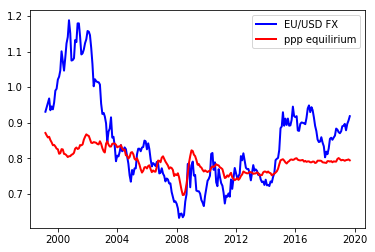

In [13]:
# Visualize the FX and the ppp-equilibrium fx
plt.plot( 'time', 'fx', data=p_df, marker='', color='blue', linewidth=2,label='EU/USD FX')
plt.plot( 'time', 'r_ppp', data=p_df, marker='', color='red', linewidth=2, label='ppp equilirium')
plt.legend()

## D. Modeling

In [14]:
#Create training data set for fx before 2016
train=p_df[p_df.year < 2016]
train=train[['time','fx_1m','s_t','x','y']]
train.tail()

,time,fx_1m,s_t,x,y
197,2015-08-01,0.892618,-0.114667,0.118332,0.001071
198,2015-09-01,0.907688,-0.113597,0.114553,0.016742
199,2015-10-01,0.945269,-0.096854,0.130467,0.040569
200,2015-11-01,0.918527,-0.056286,0.172653,-0.028699
201,2015-12-01,0.915751,-0.084984,0.142273,-0.003027


In [15]:
# Import library for modeling
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Train the model on training dataset
regr = linear_model.LinearRegression()
x = np.asanyarray(train['x']).reshape(-1, 1)
y = np.asanyarray(train['y']).reshape(-1, 1)
regr.fit (x, y)
print ('Coefficients: ', regr.coef_)

Coefficients:  [[-0.0164949]]


197    0.890555
198    0.891564
199    0.906379
200    0.943249
201    0.917023
Name: fx1m_pred, dtype: float64
197    0.892618
198    0.907688
199    0.945269
200    0.918527
201    0.915751
Name: fx_1m, dtype: float64


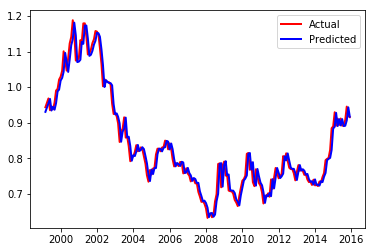

In [16]:
# Testing the model on training data set
train['y_pred']=regr.predict(x)
mse=mean_squared_error(y,train['y_pred'])
r2=r2_score(y,train['y_pred'])

# converting log to normal fx
train['fx1m_pred']=train['y_pred']+train['s_t']
#print(train['fx1m_pred'].tail())
train['fx1m_pred']=np.exp(train['fx1m_pred'])
print(train['fx1m_pred'].tail())
print(train['fx_1m'].tail())


# Visualize the predicted result
plt.plot(train['time'], train['fx_1m'], marker='', color='red', linewidth=2,label='Actual')
plt.plot(train['time'], train['fx1m_pred'], marker='', color='blue', linewidth=2, label='Predicted')
plt.legend()

In [17]:
mse=mean_squared_error(train['fx_1m'],train['fx1m_pred'])
r2=r2_score(train['fx_1m'],train['fx1m_pred'])
print('Mean square error of in-sample prediction: ', mse)
print('R-square of in-sample prediction: ', r2)

Mean square error of in-sample prediction:  0.0006454387396470907
R-square of in-sample prediction:  0.9665860028688283


**Out of sample-prediction**

In [18]:
test=p_df[p_df.year >= 2016]
test=test[['time','fx_1m','s_t','x','y']]
test.tail()

,time,fx_1m,s_t,x,y
242,2019-05-01,0.878735,-0.108944,0.122927,-0.020328
243,2019-06-01,0.896781,-0.129272,0.100236,0.020328
244,2019-07-01,0.906125,-0.108944,0.119774,0.010367
245,2019-08-01,0.918358,-0.098578,0.128534,0.013410
246,2019-09-01,0.896539,-0.085168,0.145140,-0.024045


In [19]:
x_test = np.asanyarray(test['x']).reshape(-1, 1)
test['y_pred']=regr.predict(x_test)
test.head()

,time,fx_1m,s_t,x,y,y_pred
202,2016-01-01,0.918442,-0.088011,0.135861,0.002935,-0.001533
203,2016-02-01,0.878349,-0.085076,0.137915,-0.044635,-0.001566
204,2016-03-01,0.876962,-0.129712,0.098405,-0.001580,-0.000915
205,2016-04-01,0.896539,-0.131291,0.098543,0.022078,-0.000917
206,2016-05-01,0.900739,-0.109213,0.121484,0.004673,-0.001295


In [20]:
test['fx1m_pred']=test['y_pred']+test['s_t']
test['fx1m_pred']=np.exp(test['fx1m_pred'])
mse_test=mean_squared_error(test['fx_1m'],test['fx1m_pred'])
r2_test=r2_score(test['fx_1m'],test['fx1m_pred'])
print('Mean square error of out-of-sample prediction: ', mse_test)
print('R-square of out-of-sample prediction: ', r2_test)

Mean square error of out-of-sample prediction:  0.00022883445818449542
R-square of out-of-sample prediction:  0.8077925138433002


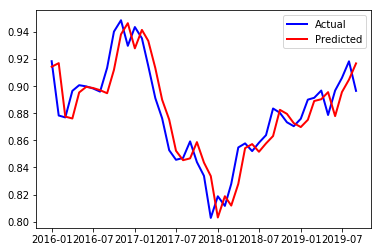

In [21]:
# Visualize the predicted result
plt.plot(test['time'], test['fx_1m'], marker='', color='blue', linewidth=2,label='Actual')
plt.plot(test['time'], test['fx1m_pred'], marker='', color='red', linewidth=2, label='Predicted')
plt.legend()

/Users/lbpham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  """Entry point for launching an IPython kernel.


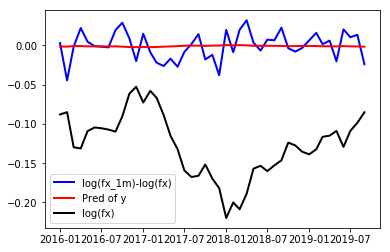

In [22]:
plt.plot( 'time','y', data=test, marker='', color='blue', linewidth=2,label='log(fx_1m)-log(fx)')
plt.plot( 'time','y_pred', data=test, marker='', color='red', linewidth=2, label='Pred of y')
plt.plot( 'time','s_t', data=test, marker='', color='black', linewidth=2, label='log(fx)')
plt.legend()